# Loan Approval Prediction using Random Forest

This notebook outlines the process of developing a predictive model for loan approvals using a Random Forest classifier. 

The objective of this analysis is to build a predictive model using a Random Forest algorithm to determine the likelihood of a loan application being approved (`loan_status`). The model will utilize the features provided in the dataset, such as the applicant's income, credit score, and asset values, to make predictions. By training the model on historical data, it will learn patterns and relationships between these features and the loan approval outcome, which can then be used to predict the approval status of new loan applications.

In [22]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from imblearn.over_sampling import SMOTE

## Loading Dataset 

### Dataset Description

This dataset contains information on loan applications, including various attributes related to the applicant's demographics, financial status, and loan details. Each row represents an individual loan application, identified by a unique `loan_id`. The following columns are included in the dataset:

- **no_of_dependents**: The number of dependents that the loan applicant has.
- **education**: The education level of the applicant, categorized as either "Graduate" or "Not Graduate".
- **self_employed**: Indicates whether the applicant is self-employed ("Yes") or not ("No").
- **income_annum**: The annual income of the applicant, measured in the local currency.
- **loan_amount**: The total amount of the loan applied for by the applicant, also measured in the local currency.
- **loan_term**: The duration of the loan in months.
- **cibil_score**: The CIBIL (Credit Information Bureau (India) Limited) score of the applicant, which is a measure of their creditworthiness.
- **residential_assets_value**: The value of the applicant's residential assets.
- **commercial_assets_value**: The value of the applicant's commercial assets.
- **luxury_assets_value**: The value of the applicant's luxury assets.
- **bank_asset_value**: The value of the assets held by the applicant in the bank.
- **loan_status**: The status of the loan application, indicating whether it was "Approved" or "Rejected".

In [23]:
df = pd.read_csv("loan_approval_dataset.csv",index_col=0,na_values=['', 'NA', 'N/A', 'null', 'None'])
# Remove spaces from column names
df.columns = df.columns.str.strip()
# Remove spaces from string values in all columns
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

df.columns

Index(['no_of_dependents', 'education', 'self_employed', 'income_annum',
       'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value',
       'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value',
       'loan_status'],
      dtype='object')

In [24]:
df

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
loan_id,,,,,,,,,,,,
1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected
...,...,...,...,...,...,...,...,...,...,...,...,...
4265,5,Graduate,Yes,1000000,2300000,12,317,2800000,500000,3300000,800000,Rejected
4266,0,Not Graduate,Yes,3300000,11300000,20,559,4200000,2900000,11000000,1900000,Approved
4267,2,Not Graduate,No,6500000,23900000,18,457,1200000,12400000,18100000,7300000,Rejected


## Data Transformation and Log Scaling

1. **Encoding Categorical Variables**:
    - The categorical variables `education`, `self_employed`, and `loan_status` are transformed into numerical values using the `.replace()` method.
    - For `education`, "Graduate" is mapped to 1, and "Not Graduate" is mapped to 0.
    - For `self_employed`, "Yes" is mapped to 1, and "No" is mapped to 0.
    - For `loan_status`, "Approved" is mapped to 1, and "Rejected" is mapped to 0 using a list comprehension that checks the value for each entry in the `loan_status` column.

2. **Ensuring Data Types Are Consistent**:
    - After replacement, the code ensures that the transformed columns (`education`, `self_employed`, and `loan_status`) are all of integer type using `.astype(int)`.

3. **Log Transformation**:
    - Continuous variables (`income_annum`, `loan_amount`, `residential_assets_value`, `commercial_assets_value`, `luxury_assets_value`, and `bank_asset_value`) are specified for log transformation to normalize their distributions, which is often beneficial for models like Random Forest.
    - Rows with zero or negative values in any of the specified columns are dropped, as the logarithm of such values is undefined or invalid.
    - Finally, a log transformation is applied to the specified columns using `np.log()` to scale the data.

These preprocessing steps help to encode the categorical variables into a format that can be understood by the Random Forest algorithm and scale the continuous variables to improve model performance.

In [4]:
# Using the replace method to transform the columns
df['education'] = df['education'].replace({'Graduate': 1, 'Not Graduate': 0})
df['self_employed'] = df['self_employed'].replace({'Yes': 1, 'No': 0})
df['loan_status'] = [1 if i == 'Approved' else 0 for i in df['loan_status']]


# Check and ensure the values are not tuples
df['education'] = df['education'].astype(int)
df['self_employed'] = df['self_employed'].astype(int)
df['loan_status'] = df['loan_status'].astype(int)

In [5]:
#Log Transformations

columns_to_log = ['income_annum', 'loan_amount', 'residential_assets_value', 
                  'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']

# Drop rows where any of the specified columns have zero or negative values
df = df[(df[columns_to_log] > 0).all(axis=1)]

# Apply the log transformation to these columns
df[columns_to_log] = df[columns_to_log].apply(np.log)

/var/folders/bb/jq2hs7g17mldxw_vtxw44yr00000gn/T/ipykernel_70416/2049960410.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_log] = df[columns_to_log].apply(np.log)


In [6]:
#Checking for NULL values 

df.isnull().sum()

no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

In [7]:
# Dropping NULL values if present 
df = df.dropna()

## Feature and Target Variable Selection

In this step, the dataset is being prepared for model training by separating the features (`X`) and the target variable (`y`). The variable `X` contains all the input features that will be used to train the model while `y` will be the target that the model is trying to predict.

In [26]:
X = df.drop("loan_status", axis = 1)

y = df[["loan_status"]]
# Convert y_train to a Series
y = y.squeeze()  # Converting DataFrame with one column into a Series

## Class Distribution Visualization

In this step, we visualize the distribution of the target variable `loan_status`, specifically checking for any imbalance between approved and not approved loans. Understanding the class distribution is crucial, especially in classification problems, because it helps to identify any imbalance between classes, which can significantly affect model performance.

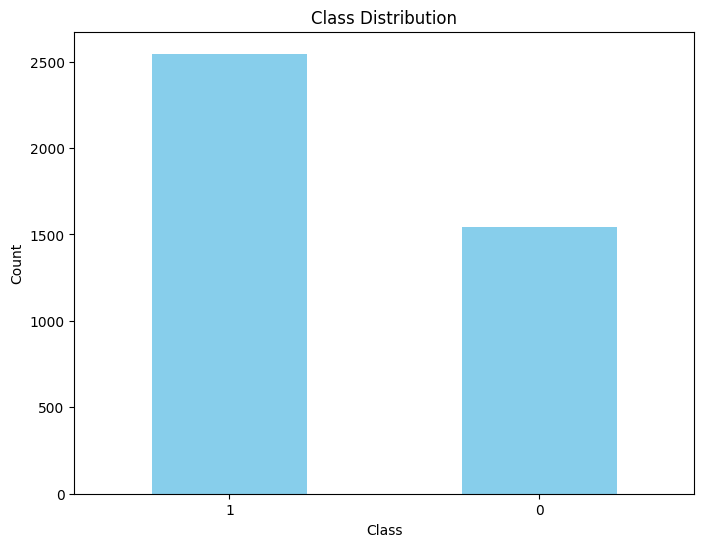

In [9]:
class_counts = y.value_counts()

plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=0)
plt.show()

#### Interpretation

The bar plot shows that there are more approved loans (Class 1) than rejected loans (Class 0). Specifically, there are approximately 2500 approved loans and around 1500 rejected loans. This indicates a moderate class imbalance, which may affect model performance by biasing predictions towards the majority class. To address this, we should balance the classes to ensure that the model does not become biased towards the majority class, leading to more accurate and fair predictions for both approved and rejected loans.

## SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) is used here to balance the classes by generating synthetic samples for the minority class. This helps to prevent the model from becoming biased towards the majority class. The code initializes SMOTE, applies it to the data, and then checks the new class distribution, confirming that the classes are now balanced.

In [10]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the data
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the distribution of the classes after SMOTE
print(y_resampled.value_counts())

# If you want to convert the resampled data back into a DataFrame
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

loan_status
1    2546
0    2546
Name: count, dtype: int64


## Splitting the dataset 

The dataset is being split into training and testing sets. The training set will be used to train the model, while the testing set will be used to evaluate the model's performance on unseen data.

In [11]:
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and target variable respectively
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=5)

## Building the Model 

### 1. GridSearch 
`GridSearchCV` is used to perform an exhaustive search over the specified hyperparameter values for a `RandomForestClassifier`. It tries all combinations of the provided parameters and evaluates them using cross-validation to determine the best set of parameters that optimize model performance.

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for GridSearchCV
parameters = {
    'n_estimators': [110, 115, 120],
    'max_depth': [9, 10, 11, 12],
    'max_features': [3, 4, 5, 6],
    'max_leaf_nodes': [9, 10, 11, 120]
}

rf.best_params_

{'max_depth': 9, 'max_features': 6, 'max_leaf_nodes': 120, 'n_estimators': 120}

### 2. Training the Model

The model is then trained using the training data (`X_train`, `y_train`) with the best hyperparameters selected by `GridSearchCV`. During this training phase, the model learns from the data to understand the patterns and relationships between the features and the target variable (`loan_status`). By utilizing the best parameters found through the grid search, the model is optimized for better performance, increasing its ability to accurately predict the outcomes on unseen data.

In [28]:
# Initialize the classifier
rf = RandomForestClassifier(random_state=42)
rf = GridSearchCV(rf, parameters, cv=5) 

# Train the model on the training data
rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [9, 10, 11, 12],
                         'max_features': [3, 4, 5, 6],
                         'max_leaf_nodes': [9, 10, 11, 120],
                         'n_estimators': [110, 115, 120]})

## Model Evaluation 

In [14]:
rf.score(X_test, y_test)

0.9887088856161022

The model has achieved a high accuracy of approximately 98.87% on the test data, indicating that it performs well on unseen data. This high score suggests that the model generalizes well, but the discrepancy between the training and test scores should be further examined to ensure the model is not overfitting.

In [15]:
rf.score(X_train, y_train)

1.0

The model has achieved perfect accuracy on the training data, meaning it correctly predicted all the training samples. However, this perfect score could indicate that the model might be overfitting, learning the training data too well and potentially failing to generalize to new data.

## Making Predictions 

In [21]:
predictions = rf.predict(X_test)

conf_matrix = confusion_matrix(y_test, predictions)

# Print the confusion matrix in a nicer format
print("\nConfusion Matrix:\n")
print(f"Predicted:\t{[0, 1]}")
print(f"Actual 0:\t{conf_matrix[0]}")
print(f"Actual 1:\t{conf_matrix[1]}")


Confusion Matrix:

Predicted:	[0, 1]
Actual 0:	[1003   17]
Actual 1:	[   6 1011]


### Confusion Matrix Analysis

- **True Positives (TP)**: 1011 - The number of correctly predicted approved loans.
- **True Negatives (TN)**: 1003 - The number of correctly predicted rejected loans.
- **False Positives (FP)**: 17 - The number of loans predicted as approved but were actually rejected.
- **False Negatives (FN)**: 6 - The number of loans predicted as rejected but were actually approved.

The confusion matrix indicates that the model performs well in distinguishing between approved and rejected loans, with very few misclassifications (17 FP and 6 FN). The low number of false negatives and false positives aligns with the high accuracy observed in the model's performance.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
report = classification_report(y_test, predictions)


# Print the metrics in a nicer format
print(f"{'Metric':<20} {'Value':<10}")
print("-" * 30)
print(f"{'Accuracy:':<20} {accuracy:.4f}")
print(f"{'Precision:':<20} {precision:.4f}")
print(f"{'Recall:':<20} {recall:.4f}")
print(f"{'F1 Score:':<20} {f1:.4f}")

# Print the classification report
print("\nClassification Report:\n")
print(report)

### Model Evaluation Metrics Interpretation

- **Accuracy**: `0.9887`
  - **Interpretation**: The model correctly predicts approximately 98.87% of the test data, indicating strong overall performance.

- **Precision**: `0.9835`
  - **Interpretation**: Of all the loans predicted as approved, 98.35% were actually approved. High precision indicates that the model has a low false positive rate.

- **Recall**: `0.9941`
  - **Interpretation**: Of all the actual approved loans, the model correctly identified 99.41% of them. High recall suggests the model has a low false negative rate.

- **F1 Score**: `0.9888`
  - **Interpretation**: The F1 Score, which balances precision and recall, is very high, confirming that the model performs well in identifying both approved and rejected loans.

In a case that predicts loan approval, **recall** is the most important metric because the goal is to reduce false negatives, meaning we want to ensure that we correctly identify as many actual approved loans as possible. Missing out on approving a loan that should have been approved (a false negative) could lead to lost opportunities for the lender and dissatisfaction among applicants. Therefore, maximizing recall is crucial in this scenario to minimize the risk of rejecting qualified applicants.